#### Setup

Amino acids serve as the fundamental building blocks of peptides and proteins. Understanding the sequence in which these amino acids are arranged can provide insights into the function and classification of proteins.

In this notebook, our primary objective is to predict the family to which a given amino acid sequence belongs. It's important to note that each sequence is associated with just one protein family.

The Pfam database is a comprehensive collection of protein families [1]. Each protein family in Pfam provides insights into a specific functional or structural role within the cell. 

We sourced our dataset from the following URL: [PFam Seed Random Split Dataset](https://www.kaggle.com/datasets/googleai/pfam-seed-random-split).

The dataset is divided into three distinct sections:

1. Training Data: This will be used to train our models.
2. Development Data: This set is primarily for validation purposes.
3. Test Data: Reserved for final evaluations to gauge the performance of our models.

Our experimental workflow will encompass the following steps:

1. Data Analysis: Dive into the dataset to understand its structure and characteristics.
2. Data Pre-processing: This includes tasks like tokenization to prepare the data for modelling.
3. Model Training: We will train two distinct deep learning models.
4. Model Testing: Evaluate the performance of our trained models using the test data.
5. Conclusion: Reflection on the findings.

In [2]:
import os, math, time, random, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer, trainers
from tokenizers.models import BPE
from sklearn.metrics import accuracy_score

##### Global variables

In [19]:
# Defining directories
data_directory = os.path.join('..', 'data', 'unprocessed')
models_dir = os.path.join('..', 'models')
train_data_dir = os.path.join(data_directory, 'train')
val_data_dir = os.path.join(data_directory, 'dev')
test_data_dir = os.path.join(data_directory, 'test')

# Whether to train on all labels (-1), or only a subset of them (specify number)
num_labels = -1

# 20 common amino acids + 4 rare amino acids, as specified in the dataset description
amino_acid_alphabet = 'ACDEFGHIKLMNPQRSTVWYXUBOZ'

##### Loading data

In [4]:
# Helper function to load datasets
def load_in_parts(*dirs):
    dfs = []
    for d in dirs:
        files = os.listdir(d)
        parts = []
        for f in files:
            parts.append(pd.read_csv(os.path.join(d, f)))
        # Concatenate parts and drop all but sequence (predictor) and family_accession (label)
        dfs.append(pd.concat(parts)[['sequence', 'family_accession']])
    return tuple(dfs)

In [5]:
train_data, val_data, test_data = load_in_parts(train_data_dir, val_data_dir, test_data_dir)

#### Data Exploration

[Training data]: 1086741 observations with 426 duplicate sequences and 424 duplicate rows
	Predictors (sequences):
		Missing sequences: 0
		Malformed sequences: 0
		Median (IQR) sequence length: 119.0 (76.0 - 195.0)
		Amino acid frequencies: {'P': 7441084, 'H': 3704587, 'E': 10859966, 'S': 10597822, 'R': 9406165, 'I': 10234455, 'L': 17062816, 'T': 9034110, 'D': 9371097, 'A': 14384873, 'G': 11845579, 'M': 3708948, 'F': 7130287, 'C': 2316115, 'V': 11913147, 'N': 6616976, 'W': 2293257, 'Q': 6250389, 'Y': 5556597, 'K': 9127832, 'O': 18, 'X': 1505, 'U': 119, 'Z': 8, 'B': 33}


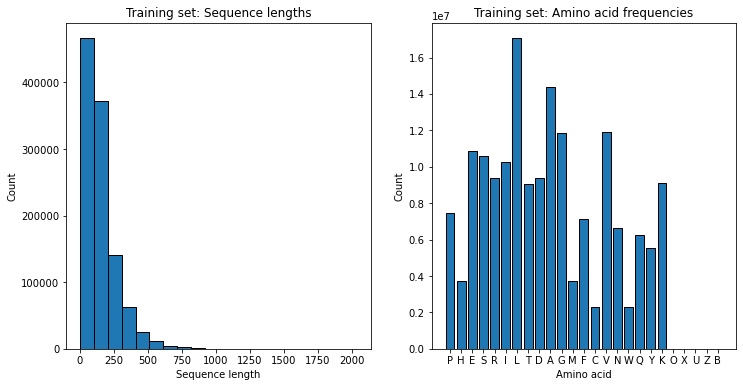

	Labels (protein families):
		Missing labels: 0
		Unique outcome classes: 17929


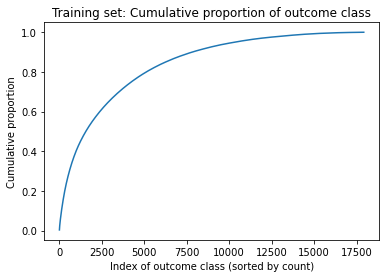

		94.50% of all samples have an outcome label within the top 10000 most frequent
[Validation data]: 126171 observations with 21 duplicate sequences and 21 duplicate rows
	Predictors (sequences):
		Missing sequences: 0
		Malformed sequences: 0
	Labels (protein families):
		Missing labels: 0
[Testing data]: 126171 observations with 10 duplicate sequences and 10 duplicate rows
	Predictors (sequences):
		Missing sequences: 0
		Malformed sequences: 0
	Labels (protein families):
		Missing labels: 0
Number of sequences in validation data that overlap with training data: 86
Number of sequences in test data that overlap with training data: 69


In [6]:
# Check for number of samples, missing values, and sanity checking
for dataset_name, dataset in [('Training data', train_data), ('Validation data', val_data), ('Testing data', test_data)]:
    print(f"[{dataset_name}]: {len(dataset)} observations with {dataset.duplicated(subset='sequence').sum()} duplicate sequences and {dataset.duplicated().sum()} duplicate rows")
    # Count the number of missing sequences
    print("\tPredictors (sequences):")
    missing_predictors = dataset['sequence'].isna().sum()
    print(f"\t\tMissing sequences: {missing_predictors}")

    # Count the number of malformed sequences
    malformed_sequence_indices = [] # Keep track of indices in case we want to view them
    sequence_lengths = []
    amino_acid_frequencies = {}
    for idx, seq in enumerate(dataset['sequence']):
        if not set(seq).issubset(set(amino_acid_alphabet)):
            malformed_sequence_indices.append(idx)
        if dataset_name == 'Training data':
            sequence_lengths.append(len(seq))
            for a in seq:
                if a in amino_acid_frequencies:
                    amino_acid_frequencies[a] += 1
                else:
                    amino_acid_frequencies[a] = 1

    print(f"\t\tMalformed sequences: {len(malformed_sequence_indices)}")
    if dataset_name == 'Training data':
        # Determine the median length and IQR of the sequences
        sequence_lengths = dataset['sequence'].apply(len)
        median_length = sequence_lengths.median()
        Q1 = sequence_lengths.quantile(0.25)
        Q3 = sequence_lengths.quantile(0.75)
        print(f"\t\tMedian (IQR) sequence length: {median_length} ({Q1} - {Q3})")

        # Plot the distribution of sequence lengths and individual amino acid frequencies
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
        ax1.hist(sequence_lengths, bins = 20, edgecolor='black')
        ax1.set_title("Training set: Sequence lengths")
        ax1.set_xlabel("Sequence length")
        ax1.set_ylabel("Count")
        ax2.bar(amino_acid_frequencies.keys(), amino_acid_frequencies.values(), edgecolor='black')
        ax2.set_title("Training set: Amino acid frequencies")
        ax2.set_xlabel("Amino acid")
        ax2.set_ylabel("Count")
        print(f"\t\tAmino acid frequencies: {amino_acid_frequencies}")
        plt.show()

    print("\tLabels (protein families):")
    # Count the number of missing labels
    missing_labels = dataset['family_accession'].isna().sum()
    print(f"\t\tMissing labels: {missing_labels}")

    # Training data-specific metrics
    if dataset_name == 'Training data':
        # Number of unique classes in the training set
        print(f"\t\tUnique outcome classes: {dataset['family_accession'].nunique()}")

        # Fetch outcome class counts, sort by most -> least frequent, and visualise their distribution
        label_counts = dataset['family_accession'].value_counts()
        label_counts_cdf = label_counts.sort_values(ascending=False).cumsum() / label_counts.sum()

        fig, ax = plt.subplots()
        ax.plot(label_counts_cdf.values)
        ax.set_title("Training set: Cumulative proportion of outcome class")
        ax.set_xlabel("Index of outcome class (sorted by count)")
        ax.set_ylabel("Cumulative proportion")
        plt.show()

        # Fetching fraction of samples with top n (e.g., 10000) outcome class
        top_n = 10000
        top_counts = label_counts.head(top_n).sum()
        percentage = (top_counts / len(dataset)) * 100
        print(f"\t\t{percentage:.2f}% of all samples have an outcome label within the top {top_n} most frequent")

# Checking for data leakage
train_sequences = set(train_data['sequence'])
val_overlap = val_data['sequence'].isin(train_sequences).sum()
test_overlap = test_data['sequence'].isin(train_sequences).sum()

print(f"Number of sequences in validation data that overlap with training data: {val_overlap}")
print(f"Number of sequences in test data that overlap with training data: {test_overlap}")

The median sequence length is 119.0 amino acids, with an interquartile range between 76.0 and 195.0. There are no malformed or missing sequences. There are 17,929 unique outcome classes in the training set with no missing labels. The cumulative plot of outcome classes indicates that their distribution in the training set is not uniform, with over 50% of the samples belonging to one of the 2,500 most represented families.

There appears to be some data leakage, with a few samples from the training set present in the validation and test sets. It is assumed that this is accidental, and that the distribution of the protein sequences is not meant to reflect their real-world distribution (which could include duplicates). Thus, we will remove these samples from the validation and the test sets in order to prevent the classifier from having an "unfair advantage".

In [7]:
train_sequences = set(train_data['sequence'])
val_data = val_data[~val_data['sequence'].isin(train_sequences)]
test_data = test_data[~test_data['sequence'].isin(train_sequences)]

There are evidently duplicate samples across all three subsets. Interestingly, the training set appears to contain two sequences with inconsistent outcomes. Let's visualise this.

In [8]:
train_data = train_data.reset_index(drop=True)

duplicate_sequence_indices = train_data[train_data.duplicated(subset='sequence', keep=False)].index
duplicate_row_indices = train_data[train_data.duplicated(keep=False)].index

inconsistent_indices = set(duplicate_sequence_indices) - set(duplicate_row_indices)
inconsistent_rows = train_data.loc[list(inconsistent_indices)]

print(inconsistent_rows[['sequence', 'family_accession']])

                                                 sequence family_accession
439917  FYGVTLTAESDSVTWDVDEDYARGQKLVIKQILLGAEAKENEFNVV...       PF03066.15
288703  DPLSEEEFYSQFYNQRVKHLCYYHRMKPYLCYQLEQFNGQAPLKGC...        PF18778.1
572821  FYGVTLTAESDSVTWDVDEDYARGQKLVIKQILLGAEAKENEFNVV...        PF17800.1
809143  DPLSEEEFYSQFYNQRVKHLCYYHRMKPYLCYQLEQFNGQAPLKGC...        PF18782.1


On investigation, the class label of the sequence at index 439917 and 572821 both refer to a similar Nucleoplasmin-related protein domain.

Similarly, the class label of the sequence at 288703 and 809143 both refer to a similar Cytidine deaminase-related protein domain.

Without knowing the reasoning behind the inconsistent labelling, we will drop these samples from the training set.

In [9]:
train_data = train_data.drop(inconsistent_indices)

Assuming duplicate samples were accidental and their distribution was not meant to represent a real-world distribution, all duplicates will be dropped across the training, validation, and test subsets.

In [10]:
train_data = train_data.drop_duplicates()
val_data = val_data.drop_duplicates()
test_data = test_data.drop_duplicates()

Finally, let's print out the number of samples per subset.

In [11]:
total_samples = len(train_data) + len(val_data) + len(test_data)

for dataset_name, dataset in [('Training data', train_data), ('Validation data', val_data), ('Testing data', test_data)]:
    num_samples = len(dataset)
    percentage = (num_samples / total_samples) * 100
    print(f"{dataset_name}: {num_samples} samples ({percentage:.2f}% of total)")

Training data: 1086313 samples (81.16% of total)
Validation data: 126083 samples (9.42% of total)
Testing data: 126101 samples (9.42% of total)


#### Pre-processing

##### Pre-processing I. (Grouping rare amino acids)

As noted above, the O, X, U, Z, and B amino acids are very rare in the dataset. We will replace these with a placeholder.

In [12]:
# Replace rare amino acids in each dataset with the same placeholder
train_data['sequence'] =  train_data['sequence'].str.replace('[OXUZB]', '#', regex=True)
val_data['sequence'] =  val_data['sequence'].str.replace('[OXUZB]', '#', regex=True)
test_data['sequence'] =  test_data['sequence'].str.replace('[OXUZB]', '#', regex=True)

##### Pre-processing II. (Training tokeniser)

We will now train a sub-word tokeniser on the sequences in the training set. This will be saved, and can be reloaded with the fourth cell below.

In [12]:
# Train and save the tokeniser
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.train_from_iterator(train_data['sequence'], trainer = trainers.BpeTrainer(vocab_size=512, special_tokens = ['[PAD]', '[UNK]', '[CLS]']))

In [ ]:
# Save the trained tokeniser
tokenizer_path = os.path.join(models_dir, 'tokenizer-aa.json')
tokenizer.save(tokenizer_path)

In [13]:
# Load the pre-trained tokeniser
tokenizer_path = os.path.join(models_dir, 'tokenizer-aa.json')
tokenizer = Tokenizer.from_file(tokenizer_path)

In [14]:
# Testing the tokeniser on an amino acid sequence
output = tokenizer.encode("XEFEEKMLELIDARIESASDDELFAGGYLRGHISLSVANCEEQG")
print(output.tokens)

['[UNK]', 'EF', 'EE', 'K', 'ML', 'EL', 'ID', 'AR', 'I', 'ES', 'AS', 'DD', 'EL', 'F', 'AG', 'GYL', 'R', 'GH', 'I', 'SL', 'SV', 'AN', 'C', 'EE', 'Q', 'G']


In [15]:
# Confirm the [PAD] index for use during training
pad_id = tokenizer.token_to_id("[PAD]")
print(pad_id)

0


##### Pre-processing III. (Tokenisation)

The amino acid sequences will now be tokenised and the distribution of tokenised sequence lengths visualised. This information will be used to obtain a 95th percentile to determine the number of tokens to truncate / pad towards (ie., the sequence length to feed to the subsequent models).

In [16]:
# Tokenize
tokenised_outputs = tokenizer.encode_batch(train_data['sequence'])
sequence_lengths = [len(output.ids) for output in tokenised_outputs]

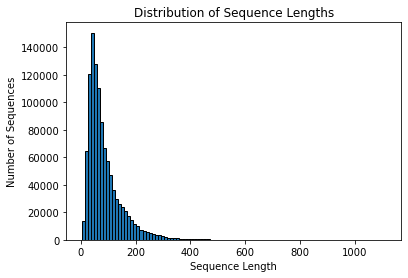

95% of the samples have a token count of 210.00 or fewer.


In [17]:
# Show the distribution of tokenized sequence lengths
fig, ax = plt.subplots()
ax.hist(sequence_lengths, bins=100, edgecolor = 'black')
ax.set_title('Distribution of Sequence Lengths')
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Number of Sequences') 
plt.show()

# Determine the 95% threshold
threshold_95 = np.percentile(sequence_lengths, 95)
print(f"95% of the samples have a token count of {threshold_95:.2f} or fewer.")

In [18]:
from tokenizers.processors import TemplateProcessing

seq_len = math.floor(threshold_95)

# Truncate and pad the sequences to 210 tokens (the 95th percentile) + 1 additional token for [CLS]
tokenizer.enable_padding(length=seq_len)
tokenizer.enable_truncation(max_length=seq_len)

# Prepend sequences with [CLS] token 
tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A",
    special_tokens=[
        ("[CLS]", tokenizer.token_to_id("[CLS]")),
    ],
)

train_data_x_padded = tokenizer.encode_batch(train_data['sequence'])
val_data_x_padded = tokenizer.encode_batch(val_data['sequence'])
test_data_x_padded = tokenizer.encode_batch(test_data['sequence'])

##### Pre-processing IV. (Final steps)

In the following cells, we will convert the outcome labels to integers. I've included an option to truncate the training set to the most frequent outcome classes (e.g., the 10,000 most frequent); however, the entire training set will be used for the subsequent exercises. Finally, we will prepare the data for PyTorch.

In [20]:
concat_labels = pd.concat([train_data['family_accession'], val_data['family_accession'], test_data['family_accession']])
label_dict = {label: idx for idx, label in enumerate(concat_labels.sort_values(ascending = False).unique())}

if num_labels == -1:
    train_data_y = train_data['family_accession'].map(label_dict).to_list()
else:
    top_n = 10000
    top_n_classes = train_data['family_accession'].value_counts().sort_values(ascending = False).index[:top_n]
    mask = train_data['family_accession'].isin(top_n_classes)
    train_data_x_padded = [tokenized_output for i, tokenized_output in enumerate(train_data_x_padded) if mask.iloc[i]]
    train_data_y = train_data['family_accession'].loc[mask].map(label_dict).to_list()

val_data_y = val_data['family_accession'].map(label_dict).to_list()
test_data_y = test_data['family_accession'].map(label_dict).to_list()

In [21]:
# Dataset and DataLoader
class SequenceDataset(Dataset):
    def __init__(self, tokenized_data, labels):
        self.tokenized_data = tokenized_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.tokenized_data[idx].ids, dtype=torch.long)
        padding_mask = (input_ids == 0)  # True for [PAD] and False otherwise
        return {
            "input_ids": input_ids,
            "padding_mask": padding_mask,
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

    
train_dataset_padded = SequenceDataset(train_data_x_padded, train_data_y)
val_dataset_padded = SequenceDataset(val_data_x_padded, val_data_y)
test_dataset_padded = SequenceDataset(test_data_x_padded, test_data_y)

batch_size = 128
torch.manual_seed(42)
train_dataloader_padded = DataLoader(train_dataset_padded, batch_size=batch_size, shuffle = True)
val_dataloader_padded = DataLoader(val_dataset_padded, batch_size=batch_size, shuffle = True)
test_dataloader_padded = DataLoader(test_dataset_padded, batch_size=batch_size, shuffle = True)


#### Model specification

In the following experiments, we will train two different neural network models. For each sample, the input is a vector derived from tokenized sequences, and the output corresponds to one of the 17,929 unique outcome classes present in the training data.

The first model employs a Bidirectional Long Short-term Memory (BiLSTM) architecture, chosen due to its efficacy in sequential data and its previous application towards amino acid sequences [2, 3]. LSTMs carry information across sequence steps within 'cells' using a cell state. This cell state is updated via information from the inputs and previous hidden states through a series of gates (forget and input). The hidden state is updated via the output gate, using information from the input, previous hidden state, and cell state. All gates carry learnable weights which are shared across the cells. The bidirectional variant processes tokens both forward and in reverse. In our model, the final hidden states from both directions are concatenated and passed through a linear layer, matching the number of classes, followed by a softmax activation.

The second model is based on the Encoder-only Transformer. Transformers, introduced by Vaswani et al., are designed for sequence tasks [4]. Unlike LSTMs that process data sequentially, Transformers use self-attention to consider different parts of the input simultaneously, allowing them to capture distant sequence dependencies. The Transformer uses attention mechanisms to create a representation of each token in context. In the encoder, multiple attention layers are stacked, each with multi-head self-attention and position-wise feed-forward networks. Residual connections and layer normalization are included for stable training. To account for token order, positional encodings are added to the input embeddings. Each input sequence to the Transformer model is prepended with a [CLS] ('classification') token. The final output encoding for this token is then passed through a linear layer, followed by a softmax activation. This approach is based on recommendations from the original paper that introduced BERT for sequence classification [5].


##### Model I. (Bidirectional LSTM)

Here, we define a Bidirectional Long Short-Term Memory (BiLSTM) neural network model. The model consists of an embedding layer, a bidirectional LSTM layer, and a linear output layer. We also set the hyperparameters, initialize the model, and prepare it for either GPU or CPU execution.

In [65]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        #self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (x, _) = self.lstm(x)
        x = torch.cat((x[-2], x[-1]), dim=1)
        #x = self.dropout(x)
        x = self.linear(x)
        return x

In [66]:
torch.manual_seed(42)

# Hyperparameters
learning_rate = 0.001
num_epochs = 300
embedding_dim = 32
hidden_dim = 128 
num_classes = train_data['family_accession'].nunique() if num_labels == -1 else num_labels
vocab_size = len(tokenizer.get_vocab())

model_bilstm = BiLSTM(vocab_size, embedding_dim, hidden_dim, num_classes)
optimizer_bilstm = optim.Adam(model_bilstm.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_bilstm = model_bilstm.to(device)

##### Model II. (Encoder-only Transformer)

Here, we first define a vectorised positional encoder, adapted from the PyTorch documentation, to provide the Transformer model with information about the position of tokens in a sequence. Following this, we establish the Transformer model structure, which comprises an embedding layer, the aforementioned positional encoding, a stack of Transformer encoder layers, and a linear output layer. After setting the hyperparameters, we initialize the Transformer model and prepare it for execution on either a GPU or CPU.

In [60]:
# Vectorised positional encoder drawn/adapted from PyTorch documentation
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = seq_len):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]
        return self.dropout(x)
    
class Transformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, dropout = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = 0)
        self.embed_dim = embed_dim
        self.positional_encoding = PositionalEncoding(embed_dim, dropout)
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, 4, hidden_dim, dropout, activation="gelu", batch_first = True) # 4 heads
        self.stacked_encoders = nn.TransformerEncoder(encoder_layer, 5) # 5 layers
        self.linear = nn.Linear(embed_dim, num_classes)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, padding_mask):
        x = self.embedding(input) * math.sqrt(self.embed_dim)
        x = self.positional_encoding(x)
        x = self.stacked_encoders(x, src_key_padding_mask=padding_mask)
        x = x[:, 0, :] # Take output embedding for [CLS] token
        output = self.linear(x)
        return output

In [61]:
torch.manual_seed(42)

# Hyperparameters
learning_rate = 0.001
num_epochs = 300
embedding_dim = 32
hidden_dim = 128
num_classes = train_data['family_accession'].nunique() if num_labels == -1 else num_labels
vocab_size = len(tokenizer.get_vocab())

model_transformer = Transformer(vocab_size, embedding_dim, hidden_dim, num_classes)
optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_transformer = model_transformer.to(device)

#### Training

Here, we initiate the training process for both models. We start by setting a random seed for reproducibility and defining early stopping criteria to prevent overfitting. During each epoch, the model is trained on the training data and subsequently evaluated on the validation set. Training and validation losses are tracked to monitor the model's performance. If the validation loss doesn't improve for a specified number of consecutive epochs (defined by 'patience'), the training is halted early, and the best model state is restored. The best model states are saved and accessible in the `data/models` directory. Therefore, one can skip to the 'Testing' section in order to evaluate the models on the test set.

##### Model I. (Bidirectional LSTM)

In [67]:
torch.manual_seed(42)

best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 5 

best_model_state = None

train_losses = []
val_losses = []

# Training loop with validation
for epoch in range(num_epochs):
    start_time = time.time()
    model_bilstm.train()
    total_loss = 0
    for batch in train_dataloader_padded:
        inputs = batch["input_ids"][:, 1:].to(device) # Skip the first token ([CLS])
        labels = batch["label"].to(device)
        optimizer_bilstm.zero_grad()
        outputs = model_bilstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_bilstm.step()
        total_loss += loss.item()

    train_losses.append(total_loss/len(train_dataloader_padded))
    
    # Validation
    model_bilstm.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_dataloader_padded:
            inputs = batch["input_ids"][:, 1:].to(device) # Skip the first token ([CLS])
            labels = batch["label"].to(device)
            outputs = model_bilstm(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_losses.append(val_loss/len(val_dataloader_padded))
    val_accuracy = accuracy_score(val_labels, val_preds)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_dataloader_padded):.4f}, Val Loss: {val_loss/len(val_dataloader_padded):.4f}, Val Accuracy: {val_accuracy:.4f} ({elapsed_time:.2f} sec)")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_model_state = model_bilstm.state_dict()
    else:
        epochs_without_improvement += 1
        
    if epochs_without_improvement >= patience:
        print(f"Early stopping due to no improvement after {patience} epochs.")
        model_bilstm.load_state_dict(best_model_state)
        break

Epoch 1/300, Train Loss: 3.6417, Val Loss: 1.4257, Val Accuracy: 0.7205 (345.70 sec)
Epoch 2/300, Train Loss: 1.0613, Val Loss: 0.7486, Val Accuracy: 0.8452 (321.08 sec)
Epoch 3/300, Train Loss: 0.5933, Val Loss: 0.5319, Val Accuracy: 0.8859 (320.95 sec)
Epoch 4/300, Train Loss: 0.3861, Val Loss: 0.4194, Val Accuracy: 0.9090 (321.05 sec)
Epoch 5/300, Train Loss: 0.2728, Val Loss: 0.3638, Val Accuracy: 0.9194 (322.36 sec)
Epoch 6/300, Train Loss: 0.2027, Val Loss: 0.3190, Val Accuracy: 0.9286 (321.35 sec)
Epoch 7/300, Train Loss: 0.1568, Val Loss: 0.2887, Val Accuracy: 0.9336 (320.97 sec)
Epoch 8/300, Train Loss: 0.1245, Val Loss: 0.2722, Val Accuracy: 0.9374 (321.35 sec)
Epoch 9/300, Train Loss: 0.1022, Val Loss: 0.2600, Val Accuracy: 0.9393 (321.63 sec)
Epoch 10/300, Train Loss: 0.0845, Val Loss: 0.2440, Val Accuracy: 0.9426 (321.42 sec)
Epoch 11/300, Train Loss: 0.0716, Val Loss: 0.2383, Val Accuracy: 0.9437 (321.35 sec)
Epoch 12/300, Train Loss: 0.0614, Val Loss: 0.2352, Val Accurac

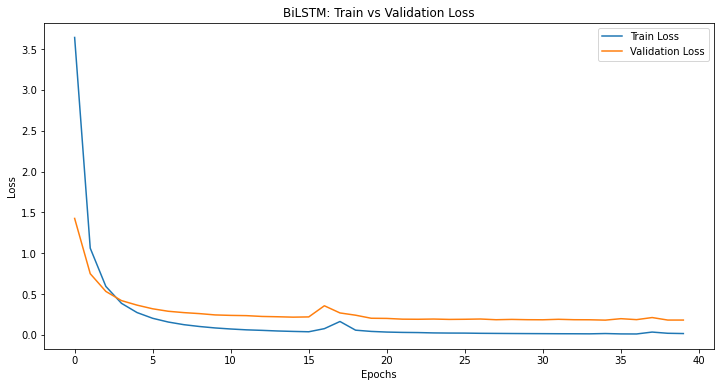

In [68]:
# Plotting training vs. validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BiLSTM: Train vs Validation Loss')
plt.legend()
plt.show()

In [69]:
# Save the best model's state dictionary
torch.save(best_model_state, os.path.join(models_dir, 'bilstm_model_correct.pth'))

# Clear model from memory
model_bilstm.to('cpu')
del model_bilstm
gc.collect()

##### Model II. (Encoder-only Transformer)

In [62]:
torch.manual_seed(42)

best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 5 

best_model_state = None

train_losses = []
val_losses = []

# Training loop with validation
for epoch in range(num_epochs):
    start_time = time.time()
    model_transformer.train()
    total_loss = 0
    for batch in train_dataloader_padded:
        inputs = batch["input_ids"].to(device)
        padding_mask = batch["padding_mask"].to(device)
        labels = batch["label"].to(device)
        optimizer_transformer.zero_grad()
        outputs = model_transformer(inputs, padding_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_transformer.parameters(), 1.) # Gradient clipping to avoid exploding gradients
        optimizer_transformer.step()
        total_loss += loss.item()

    train_losses.append(total_loss/len(train_dataloader_padded))
    
    # Validation
    model_transformer.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_dataloader_padded:
            inputs = batch["input_ids"].to(device)
            padding_mask = batch["padding_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model_transformer(inputs, padding_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_losses.append(val_loss/len(val_dataloader_padded))
    val_accuracy = accuracy_score(val_labels, val_preds)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_dataloader_padded):.4f}, Val Loss: {val_loss/len(val_dataloader_padded):.4f}, Val Accuracy: {val_accuracy:.4f} ({elapsed_time:.2f} sec)")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_model_state = model_transformer.state_dict()
    else:
        epochs_without_improvement += 1
        
    if epochs_without_improvement >= patience:
        print(f"Early stopping due to no improvement after {patience} epochs.")
        model_transformer.load_state_dict(best_model_state)
        break

Epoch 1/300, Train Loss: 5.4666, Val Loss: 3.0776, Val Accuracy: 0.3915 (609.92 sec)
Epoch 2/300, Train Loss: 2.7884, Val Loss: 1.6747, Val Accuracy: 0.6379 (605.96 sec)
Epoch 3/300, Train Loss: 1.8845, Val Loss: 1.2102, Val Accuracy: 0.7324 (605.61 sec)
Epoch 4/300, Train Loss: 1.4857, Val Loss: 0.9777, Val Accuracy: 0.7783 (611.45 sec)
Epoch 5/300, Train Loss: 1.2902, Val Loss: 0.8724, Val Accuracy: 0.8020 (604.38 sec)
Epoch 6/300, Train Loss: 1.1790, Val Loss: 0.8138, Val Accuracy: 0.8151 (603.81 sec)
Epoch 7/300, Train Loss: 1.1083, Val Loss: 0.7847, Val Accuracy: 0.8194 (602.74 sec)
Epoch 8/300, Train Loss: 1.0582, Val Loss: 0.7515, Val Accuracy: 0.8281 (603.90 sec)
Epoch 9/300, Train Loss: 1.0190, Val Loss: 0.7073, Val Accuracy: 0.8369 (603.04 sec)
Epoch 10/300, Train Loss: 0.9902, Val Loss: 0.7004, Val Accuracy: 0.8383 (607.25 sec)
Epoch 11/300, Train Loss: 0.9611, Val Loss: 0.6768, Val Accuracy: 0.8437 (612.02 sec)
Epoch 12/300, Train Loss: 0.9405, Val Loss: 0.6873, Val Accurac

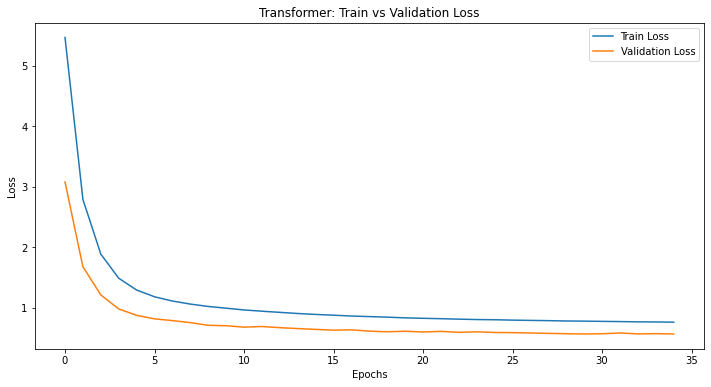

In [63]:
# Plotting training vs. validation loss
plt.figure(figsize = (12, 6))
plt.plot(train_losses, label = 'Train Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer: Train vs Validation Loss')
plt.legend()
plt.show()

In [64]:
# Save the best model's state dictionary
torch.save(best_model_state, os.path.join(models_dir, 'transformer_model.pth'))

# Clear model from memory
model_transformer.to('cpu')
del model_transformer
gc.collect()

8660

#### Testing

Here, the models are loaded from their saved checkpoints and evaluated on the test set. To execute these cells, ensure that the necessary PyTorch libraries are imported. Additionally, the data should be loaded, pre-processed, and batched into a DataLoader.

##### Model I. (Bidirectional LSTM)

In [73]:
# Loading from saved state
embedding_dim = 32
hidden_dim = 128 
num_classes = train_data['family_accession'].nunique() if num_labels == -1 else num_labels
vocab_size = len(tokenizer.get_vocab())

model_bilstm = BiLSTM(vocab_size, embedding_dim, hidden_dim, num_classes)
model_path = os.path.join(models_dir, 'bilstm_model.pth')
model_bilstm.load_state_dict(torch.load(model_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_bilstm = model_bilstm.to(device)

In [74]:
# Testing the model on the test set
model_bilstm.eval()  
test_loss = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_dataloader_padded:  
        inputs = batch["input_ids"][:, 1:].to(device) # Skip the first token ([CLS])
        labels = batch["label"].to(device)
        outputs = model_bilstm(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Loss: {test_loss/len(test_dataloader_padded):.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1797, Test Accuracy: 0.9581


The BiLSTM model achieved an accuracy of 95.81%, comparable to its performance on the validation set.

##### Model II. (Encoder-only Transformer)

In [75]:
# Hyperparameters
embedding_dim = 32
hidden_dim = 128
num_classes = train_data['family_accession'].nunique() if num_labels == -1 else num_labels
vocab_size = len(tokenizer.get_vocab())

model_transformer = Transformer(vocab_size, embedding_dim, hidden_dim, num_classes)
model_path = os.path.join(models_dir, 'transformer_model.pth')
model_transformer.load_state_dict(torch.load(model_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_transformer = model_transformer.to(device)

In [77]:
# Testing the model on the test set
model_transformer.eval()  
test_loss = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_dataloader_padded:  
        inputs = batch["input_ids"].to(device)
        padding_mask = batch["padding_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model_transformer(inputs, padding_mask)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Loss: {test_loss/len(test_dataloader_padded):.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.5687, Test Accuracy: 0.8663


The Transformer model achieved an accuracy of 86.63%, again comparable to its performance on the validation set.

#### Conclusion

The dataset in question comprised approximately 1 million amino acid sequences, each labelled with a specific protein class. In our analysis of the training data, we observed that the median sequence length stands at 119.0 amino acids. The labels in the training data encompassed 17,929 unique protein family classes, all of which are consistently labelled. No malformed sequences were identified. However, there were duplicated samples, which were subsequently removed. Moreover, some samples were found to be shared between the training and validation/test sets; these were removed from the latter.

The sequences were tokenised, then padded and truncated to 210 tokens. For the Transformer model, an additional [CLS] token was prepended to the input, and its encoding was used as input to the final output layer, in line with recommendations from BERT's authors.

The challenge was framed as a sequence classification problem, leading to the use of both a bidirectional LSTM and a Transformer architecture. In this experiment, the Bidirectional LSTM model, with an accuracy of 95.81% on the test set, surpassed the Transformer model, with an accuracy of 86.63% on the test set. This variance might be attributed to suboptimal hyperparameters in the Transformer model. Adjusting the number of attention heads, altering the learning rate, or modifying the dropout could potentially increase its performance. 

The limitations and potential further directions of this experiment include the following, in no particular order:
1. Class imbalance in the output labels was not addressed. Addressing this, perhaps through a weighted loss function, would penalise the model more for misclassifications of less frequent classes.
2. Pre-trained embeddings could be utilised, such as ProtTrans, leveraging their training on a larger corpus [6].
3. Hyperparameter tuning was not performed. This could include adjustments to the dimensionality of the embeddings, hidden layers, learning rate, batch size, dropout, number of attention heads, and activation functions.
4. Alternative processing of the LSTM and Transformer outputs could be explored. While this study used the final hidden states for the BiLSTM and the representation encoded in the [CLS] token for the Transformer, other methods like average pooling could be considered.
5. Different weight initialisation strategies could be employed, such as Xavier or drawing from a normal distribution [7].
6. Alternative networks, like the newly proposed Retentive Network, could be trialled [8].
7. JIT compilation with torch.compile could enhance the training speed.

#### References

[1] Finn, Robert D., Alex Bateman, Jody Clements, Penelope Coggill, Ruth Y. Eberhardt, Sean R. Eddy, Andreas Heger et al. "Pfam: the protein families database." Nucleic acids research 42, no. D1 (2014): D222-D230.

[2] Yu, Yong, Xiaosheng Si, Changhua Hu, and Jianxun Zhang. "A review of recurrent neural networks: LSTM cells and network architectures." Neural computation 31, no. 7 (2019): 1235-1270.

[3] Bepler, Tristan, and Bonnie Berger. "Learning protein sequence embeddings using information from structure." arXiv preprint arXiv:1902.08661 (2019).

[4] Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. "Attention is all you need." Advances in neural information processing systems 30 (2017).

[5] Devlin, Jacob, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. "Bert: Pre-training of deep bidirectional transformers for language understanding." arXiv preprint arXiv:1810.04805 (2018).

[6]  Elnaggar, Ahmed, Michael Heinzinger, Christian Dallago, Ghalia Rehawi, Yu Wang, Llion Jones, Tom Gibbs et al. "Prottrans: Toward understanding the language of life through self-supervised learning." IEEE transactions on pattern analysis and machine intelligence 44, no. 10 (2021): 7112-7127.

[7] Sun, Yutao, Li Dong, Shaohan Huang, Shuming Ma, Yuqing Xia, Jilong Xue, Jianyong Wang, and Furu Wei. "Retentive network: A successor to transformer for large language models." arXiv preprint arXiv:2307.08621 (2023).

[8] Glorot, Xavier, and Yoshua Bengio. "Understanding the difficulty of training deep feedforward neural networks." In Proceedings of the thirteenth international conference on artificial intelligence and statistics, pp. 249-256. JMLR Workshop and Conference Proceedings, 2010.